In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import os
import glob
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from pyemma.coordinates import tica
import warnings
import pandas as pd
from math import floor, log10
from tensorboard.backend.event_processing import event_accumulator

warnings.filterwarnings("ignore")
plt.style.use(['science','no-latex'])
name_dict = {'pre': 'QM (1k) Training',
             'post_cycle1': 'QM (1k) + 1 Cycle Observable Training',
             'post_cycle1_epoch10': 'QM (1k) + 10 Epochs Observable Training',
             'post_cycle1_epoch20': 'QM (1k) + 20 Epochs Observable Training',
             'post_cycle2': 'QM (1k) + 2 Cycles Observable Training',
             'post_cycle3': 'QM (1k) + 3 Cycles Observable Training',
             'post': 'QM (1k) + Observable Training',
             '10k': 'QM (10k) Training',
             '50k': 'QM (50k) Training',
             '10percent': 'QM (10%) Training',
             '25percent': 'QM (25%) Training'
            }
import matplotlib.pylab as pylab
params = {'figure.dpi': 600,
            'axes.labelsize': 'small',
          'legend.fontsize': 'x-small',
         'axes.titlesize':'small',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

def calc_cdf(stab, max_time=300):
    _cdf = np.array([(stab <= i).sum() / stab.shape[0] for i in range(max_time)])
    return _cdf

def round3(x):
    """ Round a number to 3 significant digits. """
    try:
        return round(x, 2 - int(floor(log10(abs(x)))) - 1) if x != 0 else 0
    except:
        return x
    

def plot_data_from_tfevents(exp_dir, molecule, fields):
    # Initialize an accumulator to load the tfevents file
    search_pattern = os.path.join(exp_dir, '*tfevents*')
    tfevents_files = glob.glob(search_pattern)
    ids = np.array([int(filename.split(".")[-4]) for filename in tfevents_files])
    idxs = np.argsort(ids)
    tfevents_file_path = tfevents_files[idxs[-1]] #get most recent file
                   
    ea = event_accumulator.EventAccumulator(tfevents_file_path,
                                            size_guidance={
                                                event_accumulator.SCALARS: 0
                                            })
    ea.Reload()  # Load the file
    plt.figure()
    fig, ax1 = plt.subplots()

    

    # Extract scalar data for first field
    field_data = ea.scalars.Items(fields[0])
    # Extract steps and loss values
    steps = [int(s.step) for s in field_data]
    values = [float(s.value) for s in field_data]
    ax1.plot(steps, values, 'b', label = fields[0]) 
    ax1.set_xlabel('Training Epoch')
    ax1.set_ylabel(fields[0], color='b')
    
    # Extract scalar data for second field
    field_data = ea.scalars.Items(fields[1])
    # Extract steps and loss values
    steps = [int(s.step) for s in field_data]
    values = [float(s.value) for s in field_data]
    
    # Create a second y-axis for the second plot
    ax2 = ax1.twinx()
    ax2.plot(steps, values, 'orange', label = fields[1])  # Plot the second dataset in blue
    ax2.set_ylabel(fields[1], color='orange')
    plt.title(molecule[0].upper() + molecule[1:] + " Training", fontsize=18)
    plt.show()
    

            
def plot_stability_distribution(molecule, exp_dir, names, max_time=None, cdf = False):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure()
    for name in names:
        try:
            stab = np.load(os.path.join(inference_dir, name, 'replicas_stable_time.npy'))
            if max_time is not None:
                stab = stab[stab < max_time]
        except FileNotFoundError:
            pass
        if cdf:
            _cdf = calc_cdf(stab)
            plt.plot(_cdf, label = name_dict[name], alpha=0.7)
            if 'post' in name:
                plt.xlim([0, stab.max()-1])
        else:
            plt.hist(stab, bins = 50, label = name_dict[name], density=True, alpha=0.7)
    plt.title(molecule[0].upper() + molecule[1:], fontsize=18)
    plt.legend(loc = 'upper left')
    plt.xlabel("Simulation Time (ps)" if cdf else "Stable Simulation Time (ps)", fontsize=14)
    plt.ylabel("Fraction of Unstable Replicas" if cdf else "Density", fontsize=14)
    
def plot_observable_mae_distribution(molecule, exp_dir, names, observable = 'rdf'):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure()
    for name in names:
        try:
            maes = np.load(os.path.join(inference_dir, name, f'final_{observable}_maes.npy'))
        except FileNotFoundError:
            pass
        plt.hist(maes, bins = 50, label = name_dict[name], density=True, alpha=0.7)
    plt.title(molecule[0].upper() + molecule[1:], fontsize=18)
    plt.legend(loc = 'upper right')
    plt.xlabel(f"{observable.upper()} MAE", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    

def plot_observable_mae_difference_distribution(molecule, exp_dir, names, observable = 'rdf'):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure()
    pre_maes = np.load(os.path.join(inference_dir, "pre", f'final_{observable}_maes.npy'))
    for name in names:
        if "pre" not in name and 'k' not in name:
            try:
                maes = np.load(os.path.join(inference_dir, name, f'final_{observable}_maes.npy'))
            except FileNotFoundError:
                pass
            plt.hist(100*(maes - pre_maes)/pre_maes, bins = 50, label = name_dict[name], density=True, alpha=0.7) 
    plt.title(molecule[0].upper() + molecule[1:], fontsize=18)
    plt.legend(loc = 'upper right')
    plt.xlabel(f"Change in {observable.upper()} MAE after Observable Training (%)", fontsize=8)
    plt.ylabel("Frequency", fontsize=14)
    
def plot_observable(molecule, exp_dir, names, observable = 'rdf', criterion = 'stab', mode = 'mean', diff = False):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure()
    pre_maes = np.load(os.path.join(inference_dir, "pre", f'final_{observable}_maes.npy'))
    pre_stab = np.load(os.path.join(inference_dir, "pre", 'replicas_stable_time.npy'))
    pre_obs = np.load(os.path.join(inference_dir, "pre", f'final_{observable}s.npy'))
    gt_obs = np.load(os.path.join(inference_dir, "pre", f'gt_{observable}.npy'))
    if observable == 'rdf':
        gt_obs /=2
        x_axis = np.linspace(0, 15, 750) if 'md22' in exp_dir else np.linspace(0, 10, 500)
    elif observable == 'adf':
        x_axis = np.linspace(0, np.pi, 180)
    elif observable == 'vacf':
        x_axis = np.linspace(0, 50, 100)
    
    for name in names:
        if "pre" not in name:
            try:
                maes = np.load(os.path.join(inference_dir, name, f'final_{observable}_maes.npy'))
                stab = np.load(os.path.join(inference_dir, name, 'replicas_stable_time.npy'))
                obs = np.load(os.path.join(inference_dir, name, f'final_{observable}s.npy'))
            except FileNotFoundError:
                pass
            percent_change_mae = 100*(maes - pre_maes)/pre_maes
            if mode == "max":
                mean_percent_change_mae = percent_change_mae.max()
            else:
                mean_percent_change_mae = percent_change_mae.mean()
            mean_mae_replica = np.argmin(np.abs(percent_change_mae - mean_percent_change_mae))
            if mode == 'max':
                import pdb; pdb.set_trace()
                mean_stab_imp_replica = np.argmax(stab-pre_stab)
            else:
                mean_stab_imp_replica = np.argmin(np.abs((stab-pre_stab) - np.median((stab - pre_stab))))
            replica = mean_stab_imp_replica if criterion == "stab" else mean_mae_replica
            if diff:
                plt.plot(x_axis, obs[replica] - gt_obs, label=name_dict[name])
            else:
                plt.plot(x_axis, obs[replica], label=name_dict[name])
    if diff:
        plt.plot(x_axis, pre_obs[replica] - gt_obs, label=name_dict["pre"])
    else:
        plt.plot(x_axis, pre_obs[replica], label=name_dict["pre"])
    if not diff:
        plt.plot(x_axis, gt_obs, label="Ground Truth")
    if observable == 'rdf':
        xlabel = "r (Angstroms)"
        ylabel = "h(r)"
        title  = "Distribution of Interatomic Distances"
    elif observable == 'adf':
        xlabel = "Angle (radians)"
        ylabel = "ADF"
        title  = "Angular Distribution Function"
    elif observable == 'vacf':
        xlabel = "Time lag (fs)"
        ylabel = "Normalized VACF"
        title  = "Velocity Autocorrelation Function"
    
    if diff:
        title +=" - Diff"
        ylabel +=" - Diff"
    
    plt.title(molecule[0].upper() + molecule[1:] + ": " + title, fontsize=12)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc = 'upper right')
    
    
def collect_metrics(molecule, exp_dir, names, water = False):
    inference_dir = os.path.join(exp_dir, 'inference')
    mean_rdf_maes = []
    mean_hh_rdf_maes = []
    mean_ho_rdf_maes = []
    mean_oo_rdf_maes = []
    mean_adf_maes = []
    mean_vacf_maes = []
    std_rdf_maes = []
    std_hh_rdf_maes = []
    std_ho_rdf_maes = []
    std_oo_rdf_maes = []
    std_adf_maes = []
    std_vacf_maes = []
    mean_stability = []
    std_stability = []
    mean_force_mae = []
    mean_diffusivity_maes = []
    std_diffusivity_maes = []
    used_names = []
    if len(names) == 0:
        names = os.listdir(inference_dir)
    for name in names:
        try:
            metrics = json.load(open(os.path.join(inference_dir, name, 'final_metrics.json')))
            if water:
                mean_hh_rdf_maes.append(round3(metrics['Mean HH RDF MAE']))
                mean_ho_rdf_maes.append(round3(metrics['Mean HO RDF MAE']))
                mean_oo_rdf_maes.append(round3(metrics['Mean OO RDF MAE']))
                mean_adf_maes.append(round3(metrics['Mean ADF MAE']))
                std_hh_rdf_maes.append(round3(metrics['Std Dev HH RDF MAE']))
                std_ho_rdf_maes.append(round3(metrics['Std Dev HO RDF MAE']))
                std_oo_rdf_maes.append(round3(metrics['Std Dev OO RDF MAE']))
                std_adf_maes.append(round3(metrics['Std Dev ADF MAE']))
                mean_stability.append(round3(metrics['Mean Stability (ps)']))
                std_stability.append(round3(metrics['Std Dev Stability (ps)']))
                mean_force_mae.append(round3(metrics['Force MAE']))
                mean_diffusivity_maes.append(round3(metrics["Mean Diffusivity MAE (10^-9 m^2/s)"]))
                std_diffusivity_maes.append(round3(metrics["Std Dev Diffusivity MAE (10^-9 m^2/s)"]))
            else:
                mean_rdf_maes.append(round3(metrics['Mean RDF MAE']))
                mean_adf_maes.append(round3(metrics['Mean ADF MAE']))
                mean_vacf_maes.append(round3(metrics['Mean VACF MAE']))
                std_rdf_maes.append(round3(metrics['Std Dev RDF MAE']))
                std_adf_maes.append(round3(metrics['Std Dev ADF MAE']))
                std_vacf_maes.append(round3(metrics['Std Dev VACF MAE']))
                mean_stability.append(round3(metrics['Mean Stability (ps)']))
                std_stability.append(round3(metrics['Std Dev Stability (ps)']))
                mean_force_mae.append(round3(metrics['Force MAE']))
            used_names.append(name)
        except FileNotFoundError:
            pass
        
    # Creating a DataFrame
    if water:
        data = {
            "Mean HH RDF MAE": mean_hh_rdf_maes,
            "Mean HO RDF MAE": mean_ho_rdf_maes,
            "Mean OO RDF MAE": mean_oo_rdf_maes,
            "Mean ADF MAE": mean_adf_maes,
            "Std Dev HH RDF MAE": std_hh_rdf_maes,
            "Std Dev HO RDF MAE": std_ho_rdf_maes,
            "Std Dev OO RDF MAE": std_oo_rdf_maes,
            "Std Dev ADF MAE": std_adf_maes,
            "Mean Stability (ps)": mean_stability,
            "Std Dev Stability (ps)": std_stability,
            "Mean Diffusivity MAE (10^-9 m^2/s)": mean_diffusivity_maes,
            "Std Dev Diffusivity MAE (10^-9 m^2/s)": std_diffusivity_maes,
            "Force MAE": mean_force_mae
        }
    else:
        data = {
            "Mean RDF MAE": mean_rdf_maes,
            "Mean ADF MAE": mean_adf_maes,
            "Mean VACF MAE": mean_vacf_maes,
            "Std Dev RDF MAE": std_rdf_maes,
            "Std Dev ADF MAE": std_adf_maes,
            "Std Dev VACF MAE": std_vacf_maes,
            "Mean Stability (ps)": mean_stability,
            "Std Dev Stability (ps)": std_stability,
            "Force MAE": mean_force_mae
        }
    pd.set_option('display.float_format', '{:.3g}'.format)
    df = pd.DataFrame(data, index=used_names)
    combined_df = pd.DataFrame(index=used_names)
    # Adding mean and standard deviation values in parentheses for each metric
    combined_df["Stability (ps)"] = df["Mean Stability (ps)"].astype(str) + " (" + df["Std Dev Stability (ps)"].astype(str) + ")"
    combined_df["ADF MAE"] = df["Mean ADF MAE"].astype(str) + " (" + df["Std Dev ADF MAE"].astype(str) + ")"
    combined_df["Force MAE"] = df["Force MAE"].astype(str)  # No standard deviation for Force MAE
    if water:
        combined_df["HH RDF MAE"] = df["Mean HH RDF MAE"].astype(str) + " (" + df["Std Dev HH RDF MAE"].astype(str) + ")"
        combined_df["HO RDF MAE"] = df["Mean HO RDF MAE"].astype(str) + " (" + df["Std Dev HO RDF MAE"].astype(str) + ")"
        combined_df["OO RDF MAE"] = df["Mean OO RDF MAE"].astype(str) + " (" + df["Std Dev OO RDF MAE"].astype(str) + ")"
        combined_df["Diffsivity MAE"] = df["Mean Diffusivity MAE (10^-9 m^2/s)"].astype(str) + " (" + df["Std Dev Diffusivity MAE (10^-9 m^2/s)"].astype(str) + ")"
    else:
        combined_df["RDF MAE"] = df["Mean RDF MAE"].astype(str) + " (" + df["Std Dev RDF MAE"].astype(str) + ")"
        combined_df["VACF MAE"] = df["Mean VACF MAE"].astype(str) + " (" + df["Std Dev VACF MAE"].astype(str) + ")"
    
    print(molecule)
    return combined_df.T
    
def plot_tic(molecule, exp_dir, gt_dir):
    LAG = 50
    gt_traj = np.load(gt_dir)
    
    gt_traj = gt_traj.f.R.reshape(gt_traj.f.R.shape[0] , -1)
    projected_data_gt = tica(gt_traj, lag=LAG, dim=2).get_output()[0]
    pred_traj = np.load(os.path.join(exp_dir, 'inference', 'post', 'full_traj.npy'))
    
    #this is incorrect because we have multiple replicas - need to somehow average over many trajectories
    pred_traj = pred_traj.reshape(pred_traj.shape[0]*pred_traj.shape[1], -1)
    projected_data_pred = tica(gt_traj, lag=int(LAG/50), dim=2).get_output()[0]
    
    # Determine common color scale limits
    h1, _, _ = np.histogram2d(projected_data_gt[:, 0], projected_data_gt[:, 1], bins=(100, 100))
    h2, _, _ = np.histogram2d(projected_data_pred[:, 0], projected_data_pred[:, 1], bins=(100, 100))
    vmin = min(h1.min(), h2.min())
    vmax = max(h1.max(), h2.max())
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot data on the first axis
    c1 = ax1.hist2d(projected_data_gt[:, 0], projected_data_gt[:, 1], bins=(100, 100), vmin=vmin, vmax=vmax, cmap = 'viridis')
    ax1.set_xlabel("TIC1", fontsize=14)
    ax1.set_ylabel("TIC2", fontsize=14)
    ax1.set_title('Reference', fontsize=18)

    # Plot data on the second axis
    c2 = ax2.hist2d(projected_data_pred[:, 0], projected_data_pred[:, 1], bins=(100, 100), vmin=vmin, vmax=vmax, cmap = 'viridis')
    ax2.set_xlabel("TIC1", fontsize=14)
    ax2.set_ylabel("TIC2", fontsize=14)
    ax2.set_title('Finetuned Schnet model', fontsize=18)

    # Add a single colorbar to the figure
    fig.colorbar(c1[3], ax=[ax1, ax2], orientation='vertical', pad=0.05)
    plt.show()


<Figure size 2100x1575 with 0 Axes>

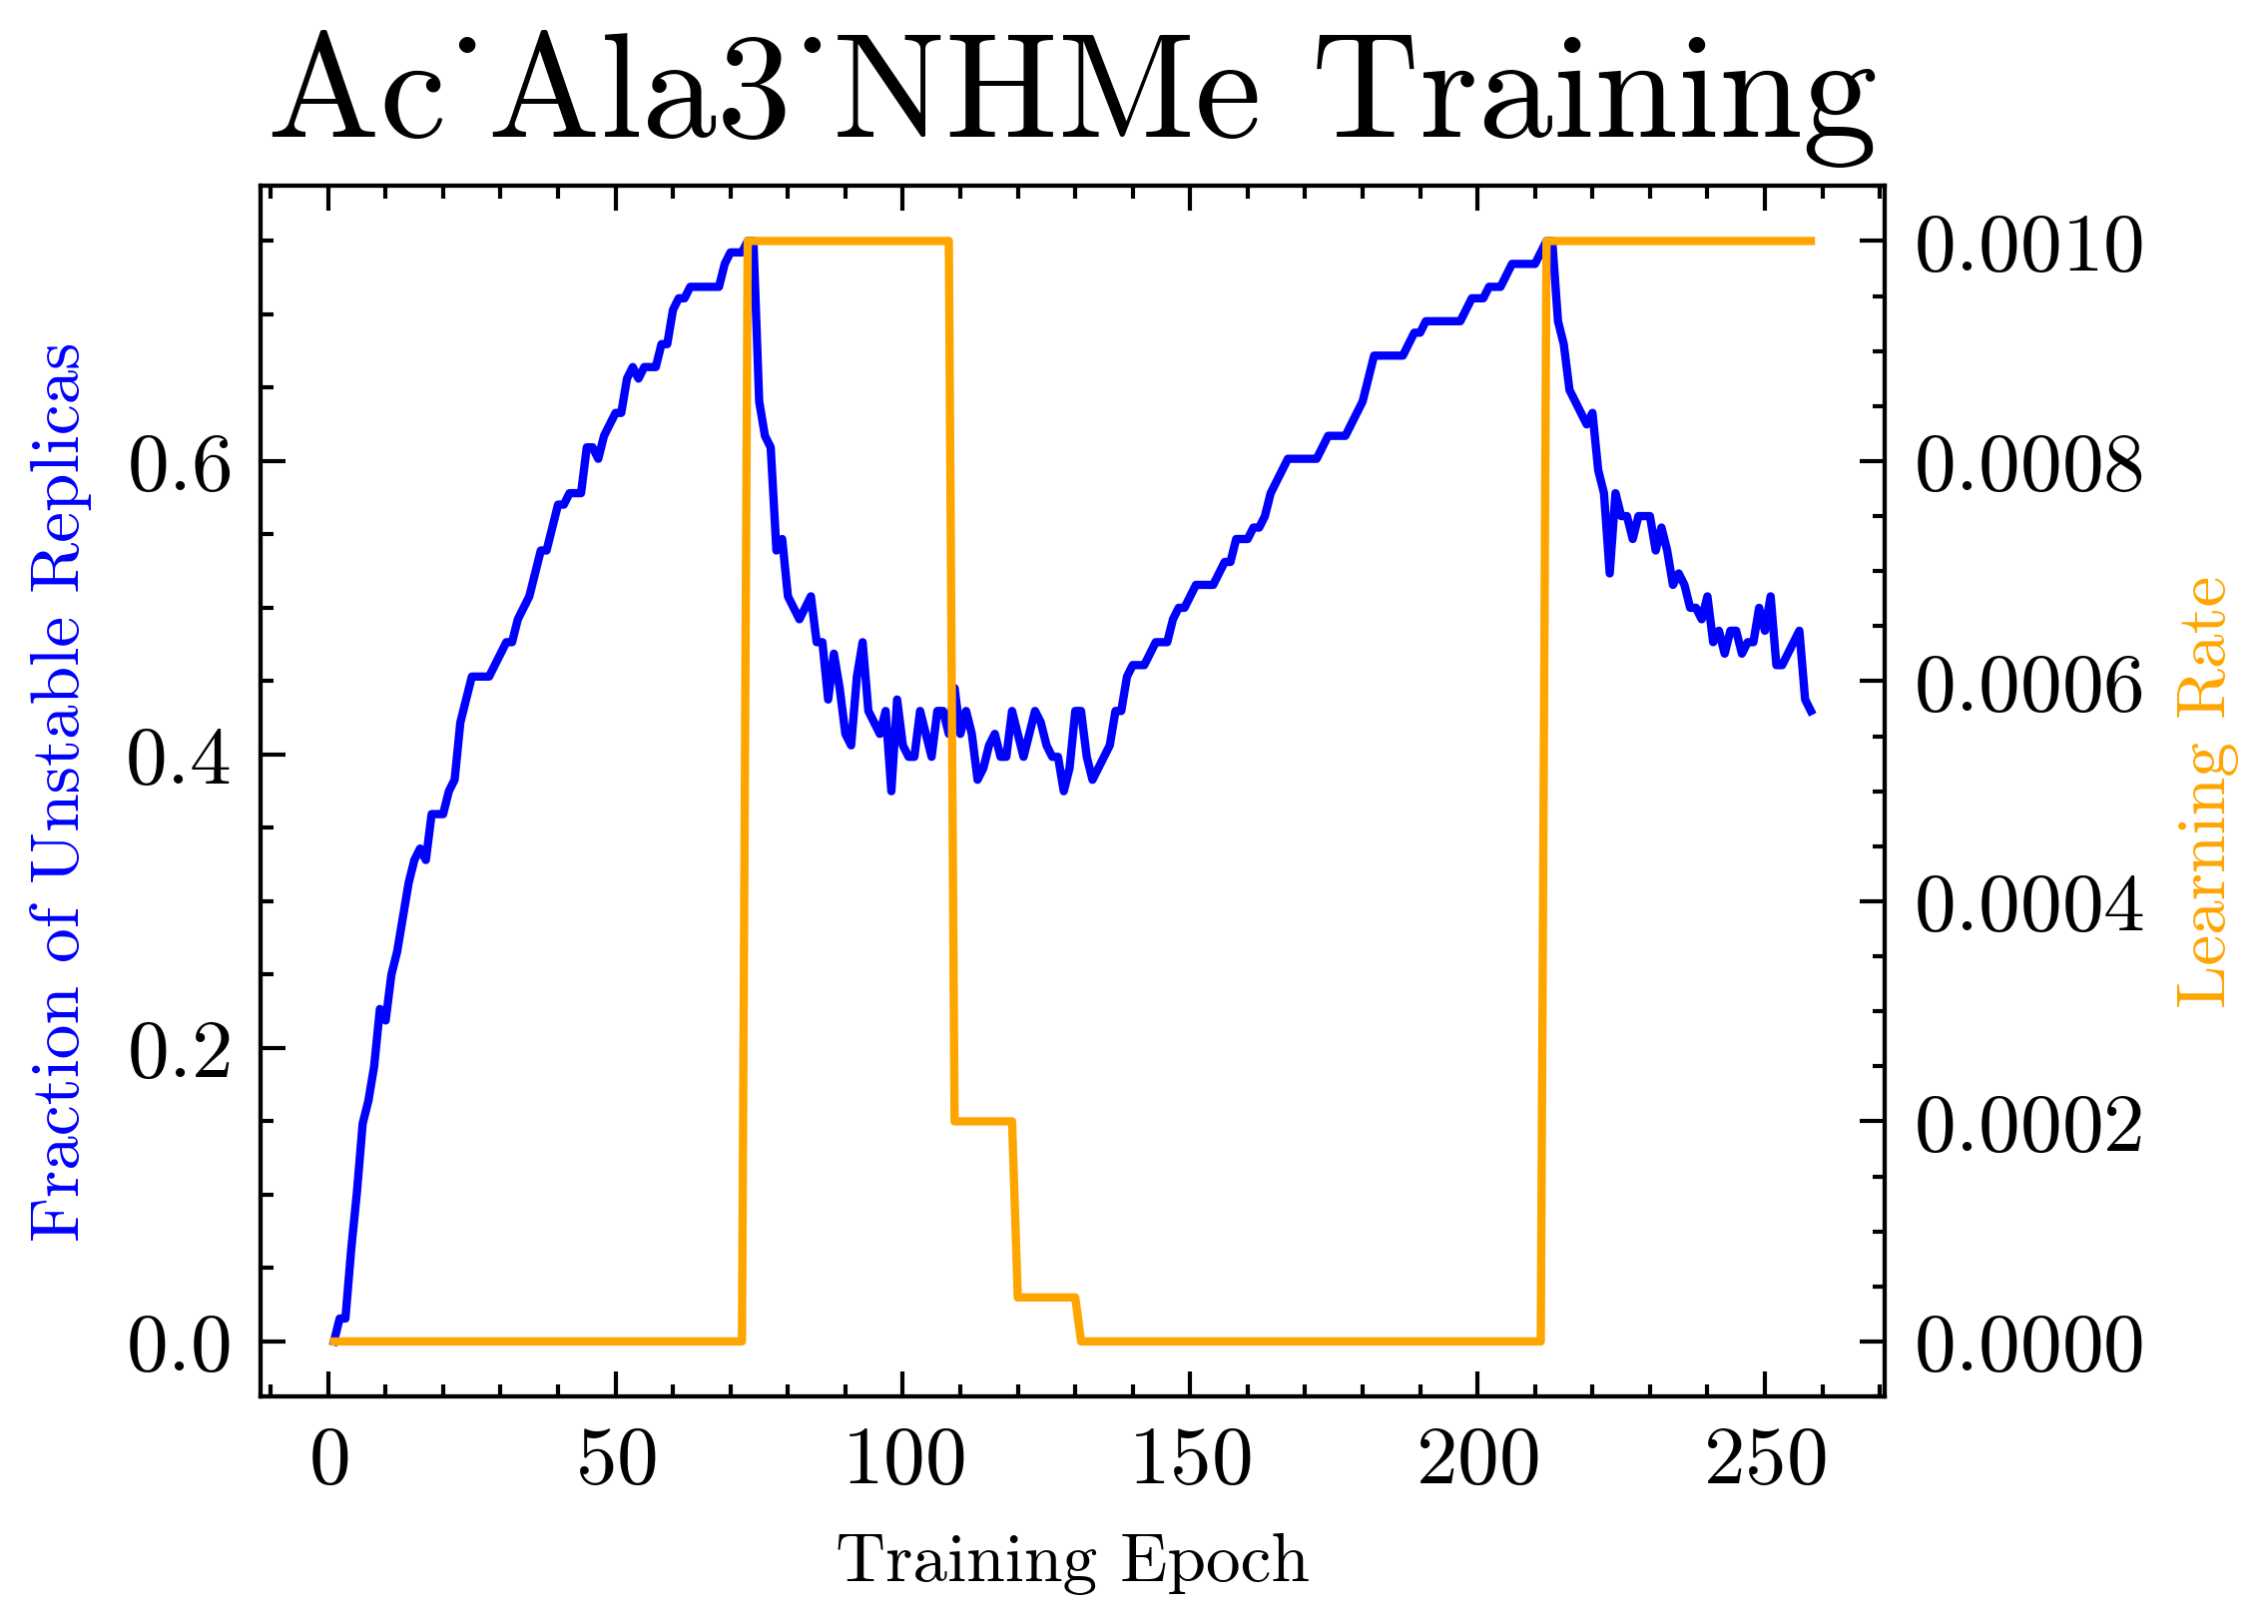

In [66]:
'''INPUTS'''
logdir = f'results_md22_final_l=1_5percent'
molecule = "ac_Ala3_NHMe"    
model = "nequip" 
lr="0.001" 
ef_weight="10" 
if molecule is None: # for water
    exp_dir = f'/global/cfs/projectdirs/m4319/sanjeevr/{logdir}/IMPLICIT_{model}_FINAL_lr={lr}_efweight={ef_weight}'
else:  
    exp_dir = f'/global/cfs/projectdirs/m4319/sanjeevr/{logdir}/IMPLICIT_{model}_{molecule}_FINAL_lr={lr}_efweight={ef_weight}'

names = ['pre', 'post_cycle1_epoch10', 'post_cycle1_epoch20', 'post_cycle1']#, 'post_cycle1_epoch20', 'post_cycle1']# 'post_cycle2', 'post_cycle3', 'post'] 
# display(collect_metrics(molecule, exp_dir, names))
fields = ["Fraction of Unstable Replicas", "Learning Rate"]
plot_data_from_tfevents(exp_dir, molecule, fields)
# plot_stability_distribution(molecule, exp_dir, names, cdf = True)
# plot_observable_mae_distribution(molecule, exp_dir, names, 'rdf')
# plot_observable_mae_distribution(molecule, exp_dir, names, 'rdf')
# plot_observable_mae_distribution(molecule, exp_dir, names, 'vacf')
# plot_observable_mae_difference_distribution(molecule, exp_dir, names, 'rdf')
# plot_observable(molecule, exp_dir, names, 'rdf', diff=False, mode = 'mean')

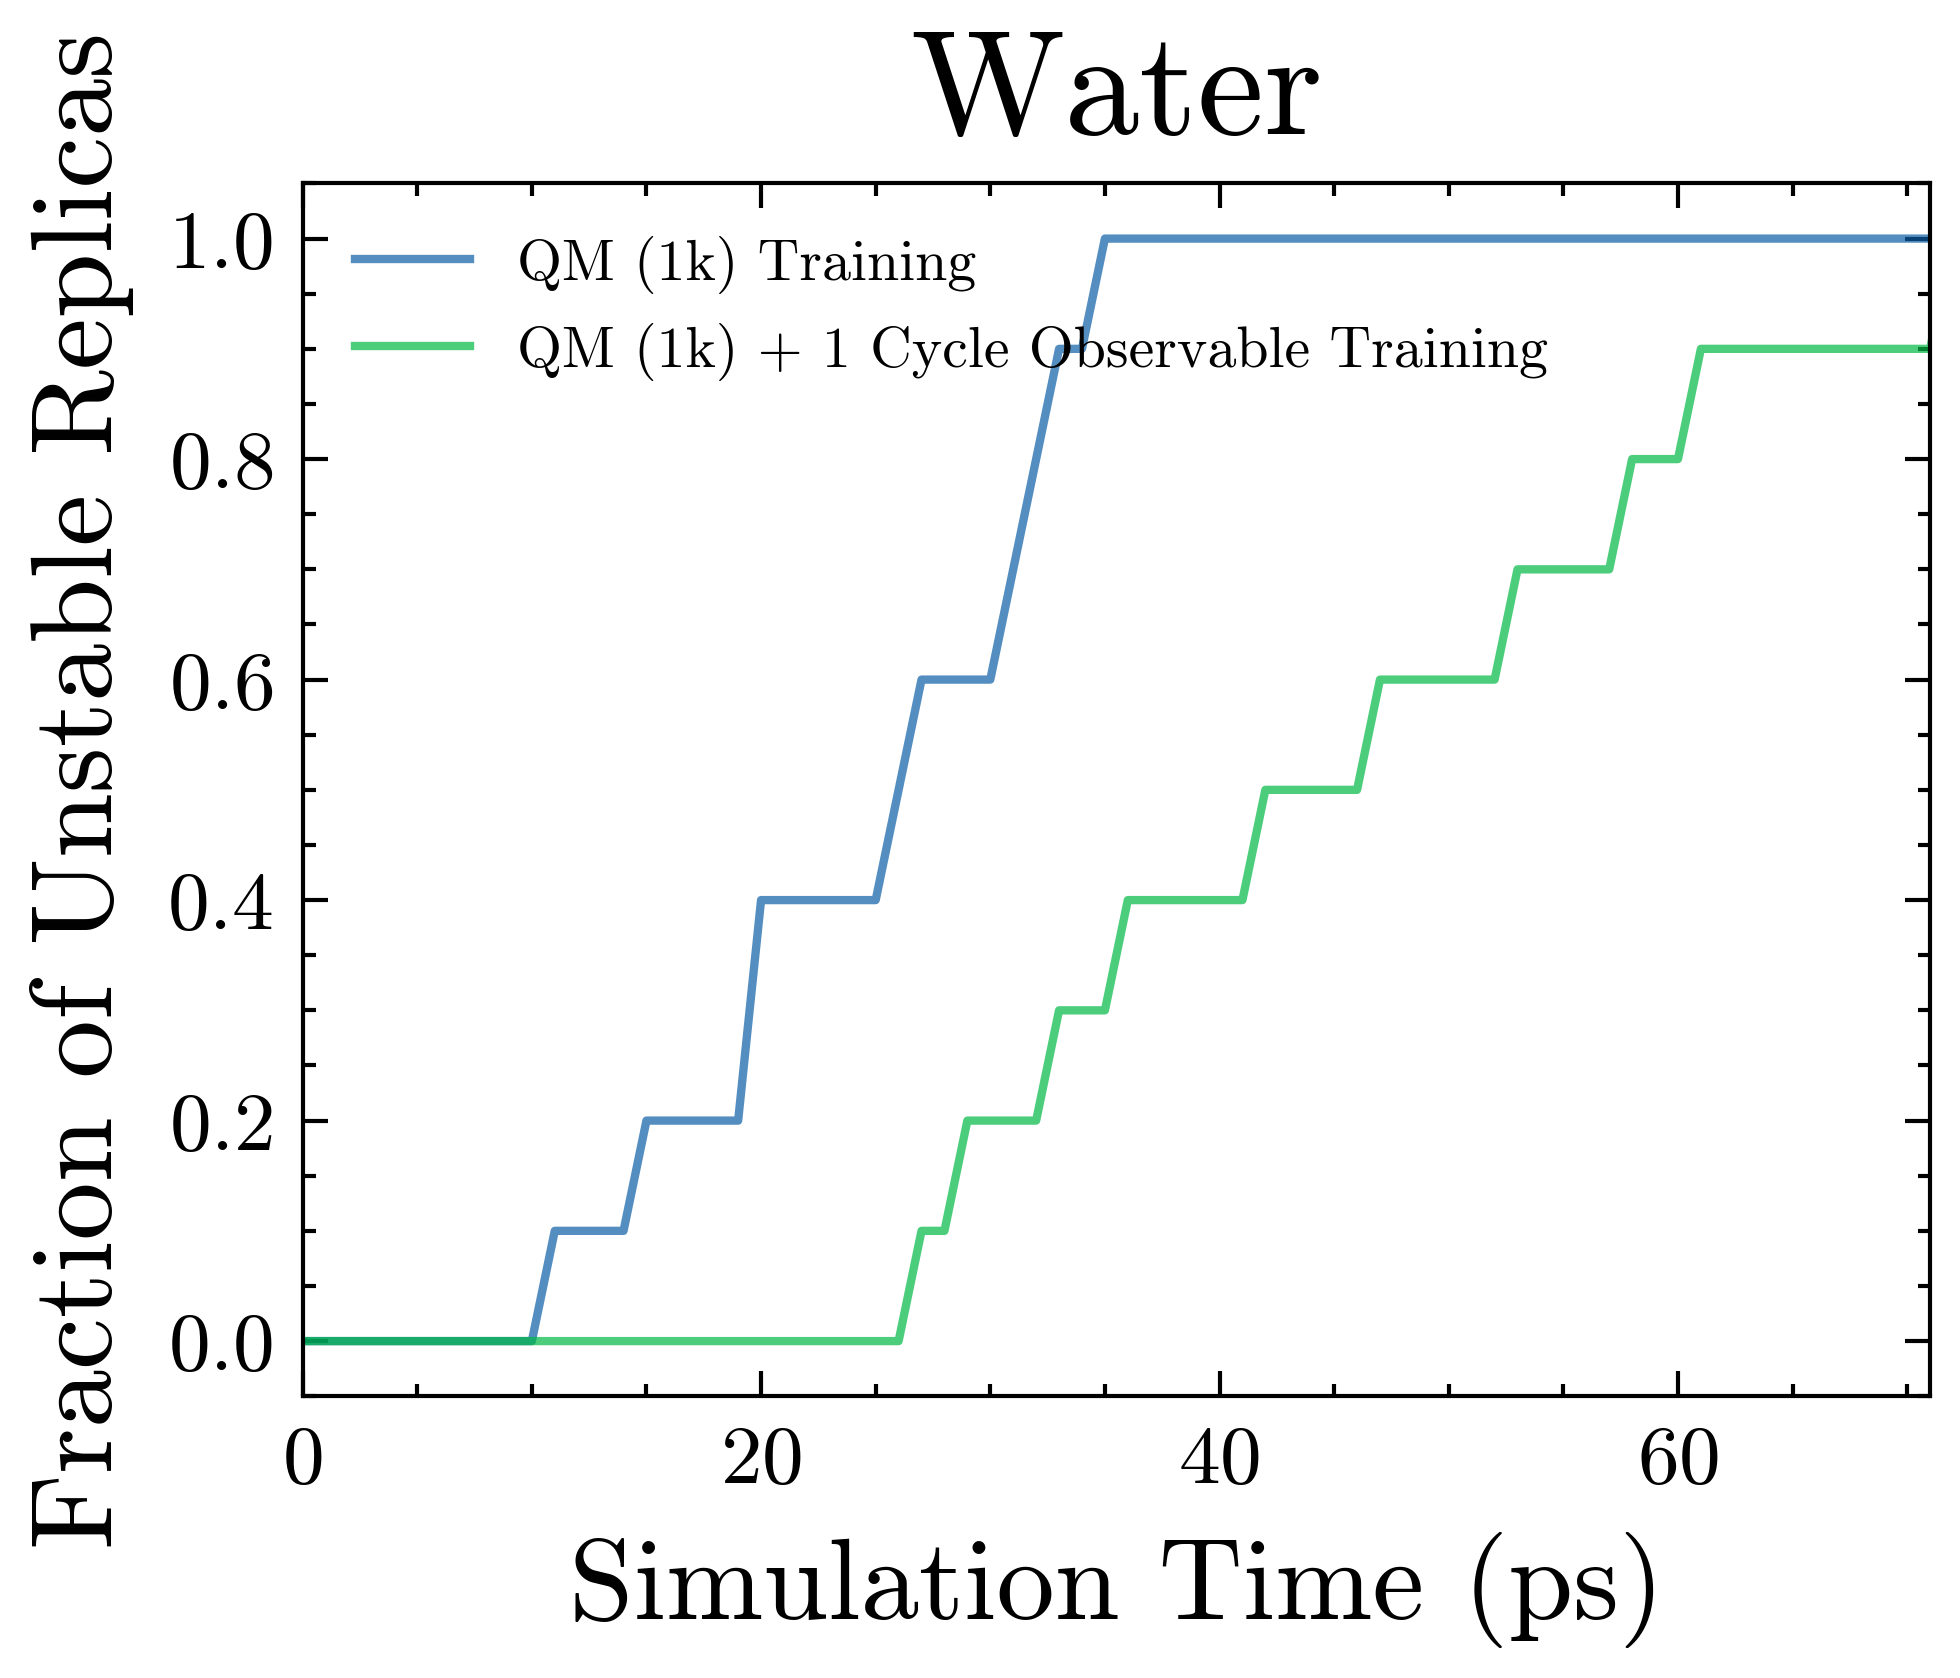

In [7]:
'''INPUTS'''
logdir = f'results_water_localneighborhoods'
molecule = 'water' 
model = "gemnet_t" 
lr="0.003" 
ef_weight="0" 
exp_dir = f'/global/cfs/projectdirs/m4319/sanjeevr/{logdir}/IMPLICIT_{model}_{molecule}_TEST_bond_length_dev_singlemolecule_lr={lr}_efweight={ef_weight}'

names = ['pre', 'post_cycle1']#, 'post_cycle1_epoch20', 'post_cycle1']# 'post_cycle2', 'post_cycle3', 'post'] 
# display(collect_metrics(molecule, exp_dir, 
#                         names, water = True))
# fields = ["Fraction of Unstable Replicas", "Learning Rate"]
# plot_data_from_tfevents(exp_dir, molecule, fields)
# plot_stability_distribution(molecule, exp_dir, names, cdf = True)
# plot_observable_mae_distribution(molecule, exp_dir, names, 'rdf')
# plot_observable_mae_distribution(molecule, exp_dir, names, 'rdf')
# plot_observable_mae_distribution(molecule, exp_dir, names, 'vacf')
# plot_observable_mae_difference_distribution(molecule, exp_dir, names, 'rdf')
# plot_observable(molecule, exp_dir, names, 'rdf', diff=False, mode = 'mean')